#### Modelling Options using a Jump Diffusion Model

Assuming the asset price evolves according to a jump diffusion model, Merton (1976) suggests the price of a European option one day later can be obtained as follows:
$$S_{t+1}=S_t*exp[(r-\xi-\lambda y-\frac{\sigma^2}{2})\frac{1}{365}+(\sigma\sqrt{\frac{1}{365}})z_1]*exp[\frac{n\gamma}{365}+(\delta\sqrt{\frac{n}{365}})z_2]$$
$z_1$ is a number from the standard normal that determines stochastic vibrations related to the normal stochastic process

$z_2$ is a number from the standard normal that determines stochastic vibrations related to the jump component of the stochastic process

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
import pandas as pd

In [2]:
def jump_diffusion(num_sims=10, dte=90, s=100, r=0.06, xi=0, lmbda=0.1, y=-0.1, sigma=0.25, delta=0.25):
    """
    Runs a monte carlo simulation under the jump diffusion model

    num_sims: number of simulations
    dte: initial dates to expiry
    s: initial price
    r: risk-free rate
    xi: dividend yield
    lmbda: rate of jumps, equal to the expected number of jumps in 365 days
    y: expected jump size
    sigma: normal return volatility
    delta: volatility of the jump size

    Returns: list of all the final price of each simulation (0 days to expiry)
    """
    #tau: time increment
    tau = 1/365
    
    sim = np.zeros(shape=[num_sims, dte+1])
    sim[:, 0] = s  # initialize all simulations to the intial price

    gamma = np.log(1+y)

    # z1: random number from standard normal that determines stochastic vibrations related to normal stochastic process
    z1 = np.random.normal(size=[num_sims, dte])

    # z2: random number from standard normal that determines stochastic vibrations related to jump component of stochastic process
    z2 = np.random.normal(size=[num_sims, dte])

    # n: number of jumps during life of option, poisson distributed with parameter lambda(1+y)tau
    n = np.random.poisson(lmbda*(1+y)*tau, size=[num_sims, dte])

    for t in range(dte):
        sim[:, t + 1] = sim[:, t] * np.exp(
            (r - xi - lmbda * y - sigma ** 2 / 2) * tau \
            + sigma * np.sqrt(tau) * z1[:, t] \
            + n[:, t]*gamma*tau \
            + delta * np.sqrt(n[:, t]*tau)*z2[:, t])

    plt.axes().set(xlabel='Days to Expiry', ylabel='Share Price ($)')
    plt.plot(np.linspace(dte, 0, dte+1), sim.T)
    plt.xlim(dte, 0)
    return sim[:,-1]

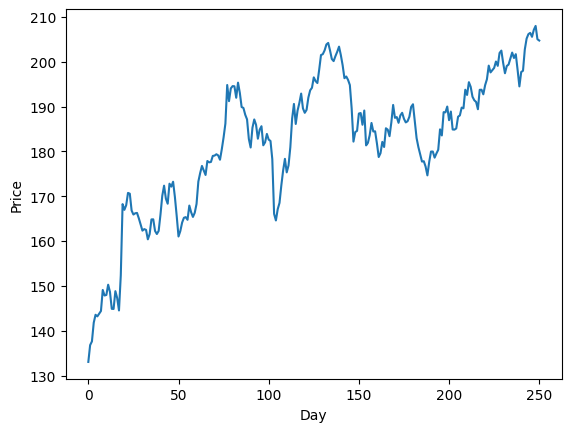

In [4]:
ticker = "FB"
year = 2

tickers_df = pd.read_csv("data/equity-data-5-years/SP500-Tickers.csv")
index = np.where(tickers_df["Symbol"] == ticker)[0][0] + 1
path = "data/equity-data-5-years/Year-" + str(year) + "/Firm-" + str(index) + ".csv"
df = pd.read_csv(path)
final_price = df.volume_weighted_average_price.tail(1).item()
log_returns = np.log(df.volume_weighted_average_price) - np.log(df.volume_weighted_average_price.shift(1))
log_returns = log_returns[~np.isnan(log_returns)].reset_index(drop = True)
df.plot(y='volume_weighted_average_price', xlabel='Day', ylabel='Price', legend=False)
plt.show()

sigma: 0.30233960697827356


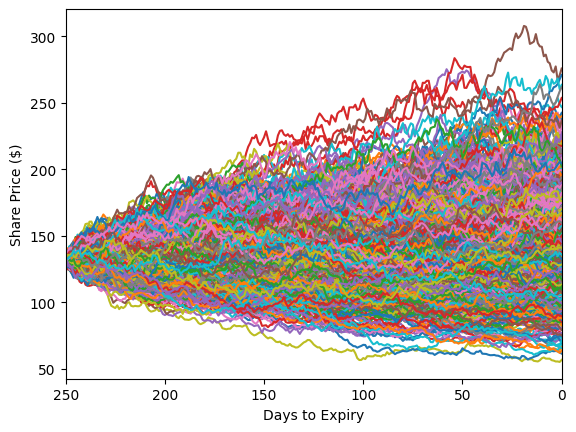

In [6]:
#Fit parameters assuming all jumps are from Brownian motion, so lambda=0
num_days = log_returns.size
one_day_vol = log_returns.std()
sigma = one_day_vol * np.sqrt(365) #annualized volatility
initial_price = df['volume_weighted_average_price'][0]
print(f"sigma: {sigma}")
data_without_jumps = jump_diffusion(num_sims=1000, dte=num_days, s=initial_price, r=0.06, xi=0, lmbda=0, y=0, sigma=sigma, delta=0)

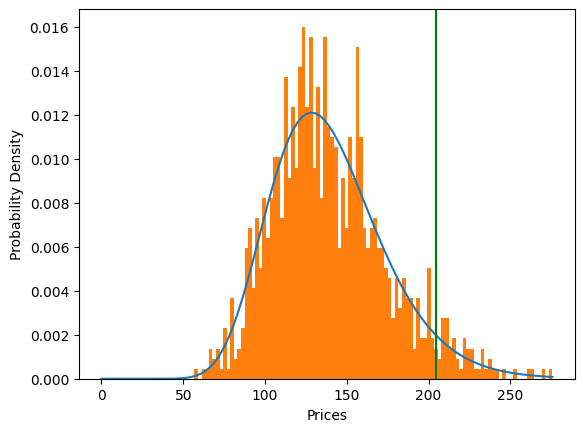

In [7]:
shape, loc, scale = stats.lognorm.fit(data_without_jumps)
x = np.linspace(0, max(data_without_jumps), 100)
pdf = stats.lognorm.pdf(x, shape, loc, scale)
plt.axes().set(xlabel='Prices', ylabel='Probability Density')
plt.plot(x, pdf)
plt.hist(data_without_jumps, bins=100, density=True)
plt.axvline(x = final_price, color = 'green', label = 'axvline - full height')
plt.show()

lambda: 10.22
y:0.011277489775348799
sigma: 0.30233960697827356
delta: 1.1034432982993772


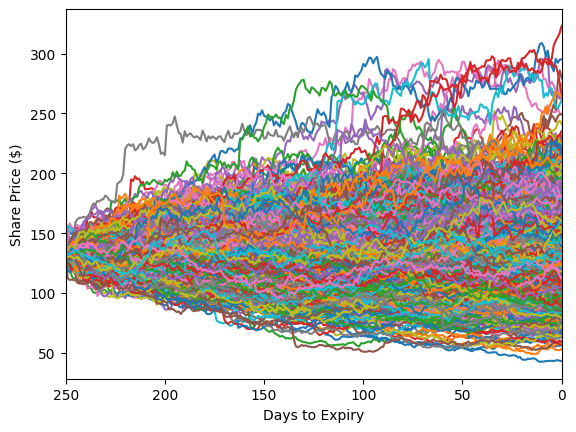

In [10]:
#Fit parameters with jumps
zscores = stats.zscore(log_returns)
outlier_indices = np.where(abs(zscores)>=2)[0]
outliers = log_returns[outlier_indices].to_numpy()

dte = log_returns.size
lmbda = 365 * outliers.size / log_returns.size
y = outliers.mean()
delta = outliers.std() * np.sqrt(365)
sigma = log_returns.std() * np.sqrt(365)
s = df['volume_weighted_average_price'][0]
data_with_jumps = jump_diffusion(num_sims=1000, dte=dte, s=s, r=0.06, xi=0, lmbda=lmbda, y=y, sigma=sigma, delta=delta)
print(f"lambda: {lmbda}\ny:{y}\nsigma: {sigma}\ndelta: {delta}")

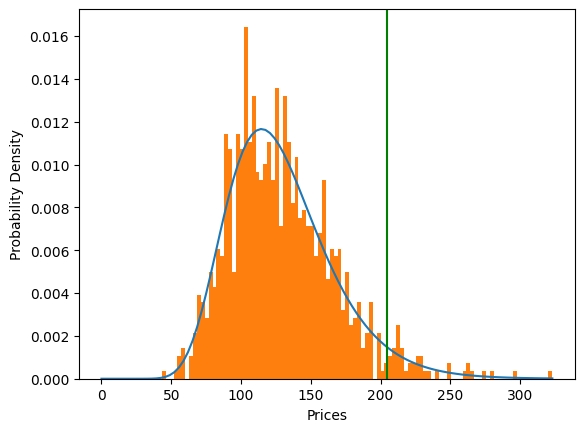

In [11]:
shape, loc, scale = stats.lognorm.fit(data_with_jumps)
fitted_data = stats.lognorm.rvs(shape,loc, scale, size=len(data_with_jumps))
x=np.linspace(0,max(data_with_jumps),100)
pdf = stats.lognorm.pdf(x, shape, loc, scale)
plt.axes().set(xlabel='Prices', ylabel='Probability Density')
plt.plot(x, pdf)
plt.hist(data_with_jumps, bins=100, density=True)
plt.axvline(x = final_price, color = 'green', label = 'axvline - full height')
plt.show()